In [2]:
! git init
! git remote add origin https://github.com/hashemkhodor/quadrature-ML.git
! git pull origin master

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 668 (delta 57), reused 50 (delta 50), pack-reused 596 (from 1)
Receiving objects: 100% (668/668), 55.30 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (271/271), done.
From https://github.com/hashemkhodor/quadrature-ML
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


Integrating RL with SINDY is a bit harder than with LSTM that's why we chose LSTM after trainig the sindy model, to simplify the process of integrating the RL agent.

In [3]:
import json

with open("results/eval_all.json") as f:
    results = json.loads(f.read())


## 🌪️ Lorenz System Definition and Data Generation

This section sets up the core Lorenz system dynamics and provides flexible tools to generate data using either **fixed time steps** or **adaptive time steps** derived from a reinforcement learning (RL) policy.

---

### 🧩 Libraries and Setup

We import numerical computing libraries (`numpy`, `scipy`), data processing (`pandas`), machine learning utilities (`keras`, `sklearn`), and plotting (`matplotlib`).

Notably:
- `solve_ivp` is used to numerically solve the Lorenz ODEs.
- `dt_values` are loaded from the result of a previously trained RL agent — in this case, the **RKDP integrator with a linear reward function**.

> 🛠️ **To change the integrator or reward function**, simply switch the key in:
> ```python
> dt_values = np.array(results['rkdp']['linear']['time_steps'])
> ```
> For example:  
> - `'rkdp' → 'cash_karp'`  
> - `'linear' → 'log'`, `'quadratic'`, etc.

---

### 🧮 Lorenz Dynamics

The `lorenz` function defines the famous 3-variable chaotic system:

\[
\begin{align*}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{align*}
\]

You can modify the parameters \( \sigma \), \( \rho \), and \( \beta \) in the `lorenz()` function to explore different dynamical behaviors.

---

### 🔁 Data Generation Function

`generate_lorenz_data()` supports two modes:

- **Fixed-Step Mode**:
  - `adaptive=False`
  - Uses a constant time step `t_eval_step` (default = 0.1)
- **Adaptive-Step Mode**:
  - `adaptive=True`
  - Uses the precomputed time steps `dt_values` from the RL policy

> 🛠️ To adjust how long the system is simulated:
> - Change `t_span=(start_time, end_time)`
>
> 🛠️ To change the initial condition:
> - Modify `init_state=[x0, y0, z0]`

---

### 💾 Save Generated Data

The `save_data_to_csv()` function stores the resulting trajectory into a CSV file:
- Output columns: `x`, `y`, `z`
- Default save path: `data/lorenz_data.csv`

> 🛠️ You can change the filename or destination by setting the `filename` argument.


In [20]:
# @title 🌪️ Lorenz System Definition
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.integrate import solve_ivp
import joblib
#HERE WE USE ANY OF THE RL AGENTS WE TRAINED, IN THIS CASE WE CHOSE RKDP WITH LINEAR REWARD FUNCTION
dt_values = np.array(results['rkdp']['linear']['time_steps'])

def lorenz(t, state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# def generate_lorenz_data(t_span=(0, 20), t_eval_step=0.01, init_state=[1, 1, 1]):

#     t_eval = np.arange(t_span[0], t_span[1], t_eval_step)
#     sol = solve_ivp(lorenz, t_span, init_state, t_eval=t_eval)
#     return sol.t, sol.y.T, t_eval_step

# def generate_lorenz_data_adaptive(t_span=(0, 20), t_eval_step=0.01, init_state=[1, 1, 1]):

#     t_eval = np.cumsum([0] + dt_values)
#     t_span = (t_eval[0], t_eval[-1])

#     sol = solve_ivp(lorenz, t_span, init_state, t_eval=t_eval)
#     return sol.t, sol.y.T
def generate_lorenz_data(t_span=(0, 20), t_eval_step=0.1, init_state=[10, 10, 10], adaptive=False):
    if adaptive:
        t_eval = np.cumsum([0] + list(dt_values))
        t_span = (t_eval[0], t_eval[-1])
    else:
        t_eval = np.arange(t_span[0], t_span[1], t_eval_step)

    sol = solve_ivp(lorenz, t_span, init_state, t_eval=t_eval)

    if adaptive:

      return sol.t, sol.y.T

    return sol.t, sol.y.T, t_eval_step


    # t_eval = np.arange(t_span[0], t_span[1], t_eval_step)
    # sol = solve_ivp(lorenz, t_span, init_state, t_eval=t_eval)
    # return sol.t, sol.y.T, t_eval_step

def save_data_to_csv(data, filename="data/lorenz_data.csv"):
    os.makedirs("data", exist_ok=True)
    pd.DataFrame(data, columns=["x", "y", "z"]).to_csv(filename, index=False)


HERE ONE CAN CHANGE DT TO USE DIFFERENT NON ADAPTIVE MODELS, AND TO GEENRATE THE DATA FOR THE GCD OF ALL THE TIME STEPS TO HAVE ALL THE DATA READY FOR WHATEVER TIME STEP THE AGENT GIVES US

In [16]:
# @title 🧼 Preprocess Lorenz Data (with dt as input)
def preprocess_data(seq_length=10, test_size=2000, dt=0.01, adaptive:bool=True):
    df = pd.read_csv("data/lorenz_data.csv")
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df)

    if adaptive:
        dt_column = dt_values.reshape(-1, 1)
    else:
        dt_column = np.full((len(data_scaled), 1), dt)
    # Let dt_column be
    data_with_dt = np.hstack((data_scaled[:len(dt_column)], dt_column))

    X, y = [], []
    for i in range(len(data_with_dt) - seq_length - 1):
        X.append(data_with_dt[i:i + seq_length])
        delta = data_scaled[i + seq_length] - data_scaled[i + seq_length - 1]
        y.append(delta)

    X = np.array(X)
    y = np.array(y)

    if test_size < len(X):
        X_train = X[:-test_size]
        y_train = y[:-test_size]
        X_test = X[-test_size:]
        y_test = y[-test_size:]
    else:
        X_train, y_train, X_test, y_test = X, y, X, y

    np.savez("data/processed_data_dt.npz", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    joblib.dump(scaler, "data/scaler.pkl")
    return scaler


In [6]:
# @title 🧠 Build LSTM Model with dt
def build_lstm_with_dt(seq_length=10, input_dim=4):
    model = Sequential([
        LSTM(32, input_shape=(seq_length, input_dim), return_sequences=True),
        Dropout(0.2),
        LSTM(16),
        Dropout(0.2),
        Dense(3)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model


In [7]:
# @title 📊 Plotting Functions
def plot_loss_curve(history, filename, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Model Loss Curve')
    if os.path.dirname(filename):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
    plt.savefig(filename)
    plt.show()

def visualize_model(model_path):
    model = load_model(model_path)
    scaler = joblib.load("data/scaler.pkl")
    data = np.load("data/processed_data_dt.npz")
    X_test, y_test = data["X_test"], data["y_test"]

    y_pred = model.predict(X_test)

    components = ['dx', 'dy', 'dz']
    plt.figure(figsize=(15, 10))

    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(y_test[:, i], label=f'True {components[i]}', alpha=0.7)
        plt.plot(y_pred[:, i], label=f'Predicted {components[i]}', alpha=0.7)
        plt.legend()
        plt.title(f"LSTM Prediction vs Ground Truth ({components[i]})")

    plt.tight_layout()
    plt.show()



This is just a function to be able to save the time it takes for each model to finish running.

In [8]:
# @title TIMER
import time
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Decorator to time functions
def timed(fn):
    def wrapper(*args, **kwargs):
        print(f"\n⏱️ Starting '{fn.__name__}'...")
        start = time.time()
        result = fn(*args, **kwargs)
        end = time.time()
        print(f"✅ Finished '{fn.__name__}' in {end - start:.2f} seconds.\n")
        return result
    return wrapper

AS YOU CAN SEE HERE WE HAVE TWO FUNCTIONS, RUN ADAPTIVE AND RUN NON ADAPTIVE, AND AS THE NAME INDICATES ONE IS FOR THE FIXED TIME STEP AND THE OTHER USES THE PRECOMPUTED TIME STEPS FROM THE RL AGENT

In [13]:
# @title 🚀 Run Full Pipeline
# Step 1: Generate data if not exists

@timed
def run_adaptive():
    t, data = generate_lorenz_data(adaptive=True)
    save_data_to_csv(data)

    scaler = preprocess_data()

    data = np.load("data/processed_data_dt.npz")
    X_train, y_train = data["X_train"], data["y_train"]
    X_test, y_test = data["X_test"], data["y_test"]

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lstm_model = build_lstm_with_dt(seq_length=X_train.shape[1], input_dim=X_train.shape[2])
    history = lstm_model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stop]
    )

    # Step 5: Save Model & Plot
    os.makedirs("saved_models", exist_ok=True)
    lstm_model.save("saved_models/adaptive/lstm_model_with_dt.h5")

    os.makedirs("results", exist_ok=True)
    plot_loss_curve(history, "results/adaptive/lstm_loss_curve_with_dt.png", "LSTM with adaptive dt")

    # Step 6: Visualize Prediction
    visualize_model("saved_models/adaptive/lstm_model_with_dt.h5")


@timed
def run_non_adaptive():
    t, data, dt = generate_lorenz_data(adaptive=False)
    save_data_to_csv(data)

    scaler = preprocess_data(adaptive=False)

    data = np.load("data/processed_data_dt.npz")
    X_train, y_train = data["X_train"], data["y_train"]
    X_test, y_test = data["X_test"], data["y_test"]

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lstm_model = build_lstm_with_dt(seq_length=X_train.shape[1], input_dim=X_train.shape[2])
    history = lstm_model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stop]
    )

    # Step 5: Save Model & Plot
    os.makedirs("saved_models", exist_ok=True)
    lstm_model.save("saved_models/adaptive/lstm_model_with_dt.h5")

    os.makedirs("results", exist_ok=True)
    plot_loss_curve(history, "results/adaptive/lstm_loss_curve_with_dt.png", "LSTM with adaptive dt")

    # Step 6: Visualize Prediction
    visualize_model("saved_models/adaptive/lstm_model_with_dt.h5")


# if not os.path.exists("data/lorenz_data.csv"):
#     t, data, dt = generate_lorenz_data()
#     save_data_to_csv(data)
# else:
#     dt = 0.01

# # Step 2: Preprocess
# scaler = preprocess_data(dt=dt)

# # Step 3: Load Data
# data = np.load("data/processed_data_dt.npz")
# X_train, y_train = data["X_train"], data["y_train"]
# X_test, y_test = data["X_test"], data["y_test"]

# # Step 4: Train Model
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# lstm_model = build_lstm_with_dt(seq_length=X_train.shape[1], input_dim=X_train.shape[2])
# history = lstm_model.fit(
#     X_train, y_train,
#     epochs=50,
#     batch_size=64,
#     validation_data=(X_test, y_test),
#     callbacks=[early_stop]
# )

# # Step 5: Save Model & Plot
# os.makedirs("saved_models", exist_ok=True)
# lstm_model.save("saved_models/lstm_model_with_dt.h5")

# os.makedirs("results", exist_ok=True)
# plot_loss_curve(history, "results/lstm_loss_curve_with_dt.png", "LSTM with dt")

# # Step 6: Visualize Prediction
# visualize_model("saved_models/lstm_model_with_dt.h5")



⏱️ Starting 'run_adaptive'...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0034 - val_l

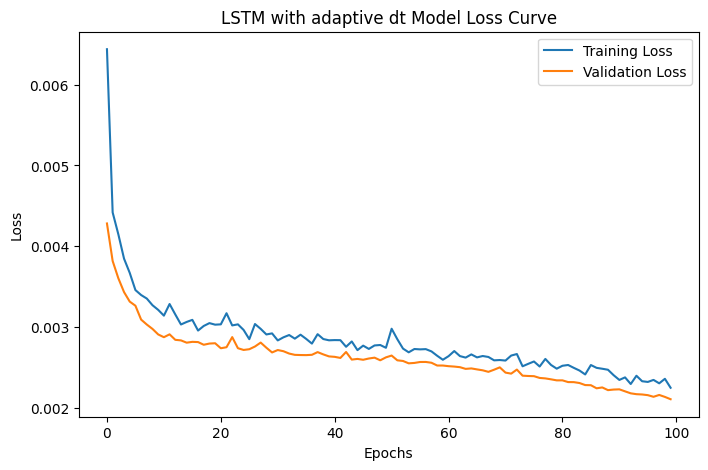

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


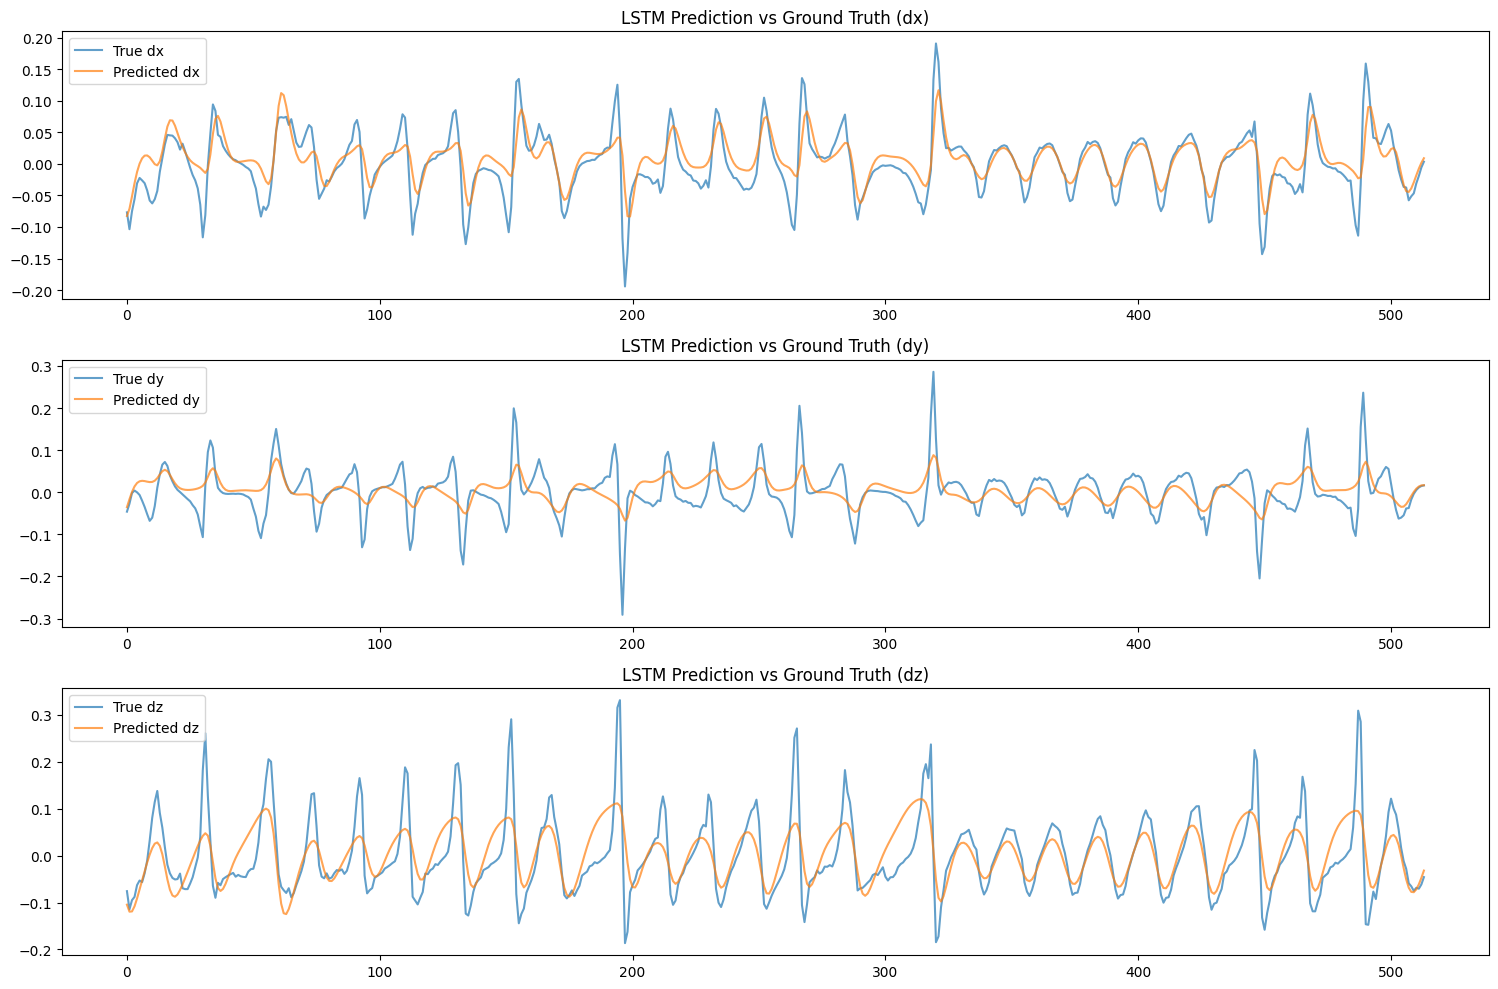

✅ Finished 'run_adaptive' in 29.06 seconds.



In [10]:
run_adaptive()


⏱️ Starting 'run_non_adaptive'...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.0275 - val_loss: 0.0231
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0259 - val_loss: 0.0230
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0258 - val_loss: 0.0227
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0250 - val_loss: 0.0227
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0242 - val_loss: 0.0225
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0247 - val_loss: 0.0225
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0234 - val_loss: 0.0224
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0234 - val_loss: 0.0223
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0226 - val_loss: 0.0223
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0223 - val_loss: 0.0222
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0227 - val_loss: 0.0222
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0225 - val_loss: 0.0221


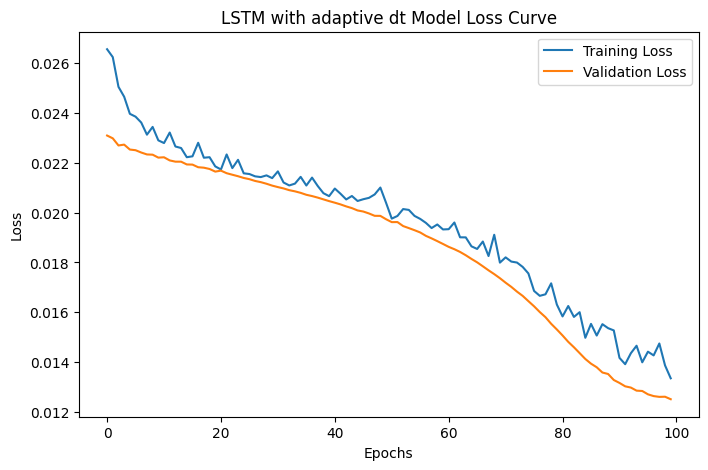

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


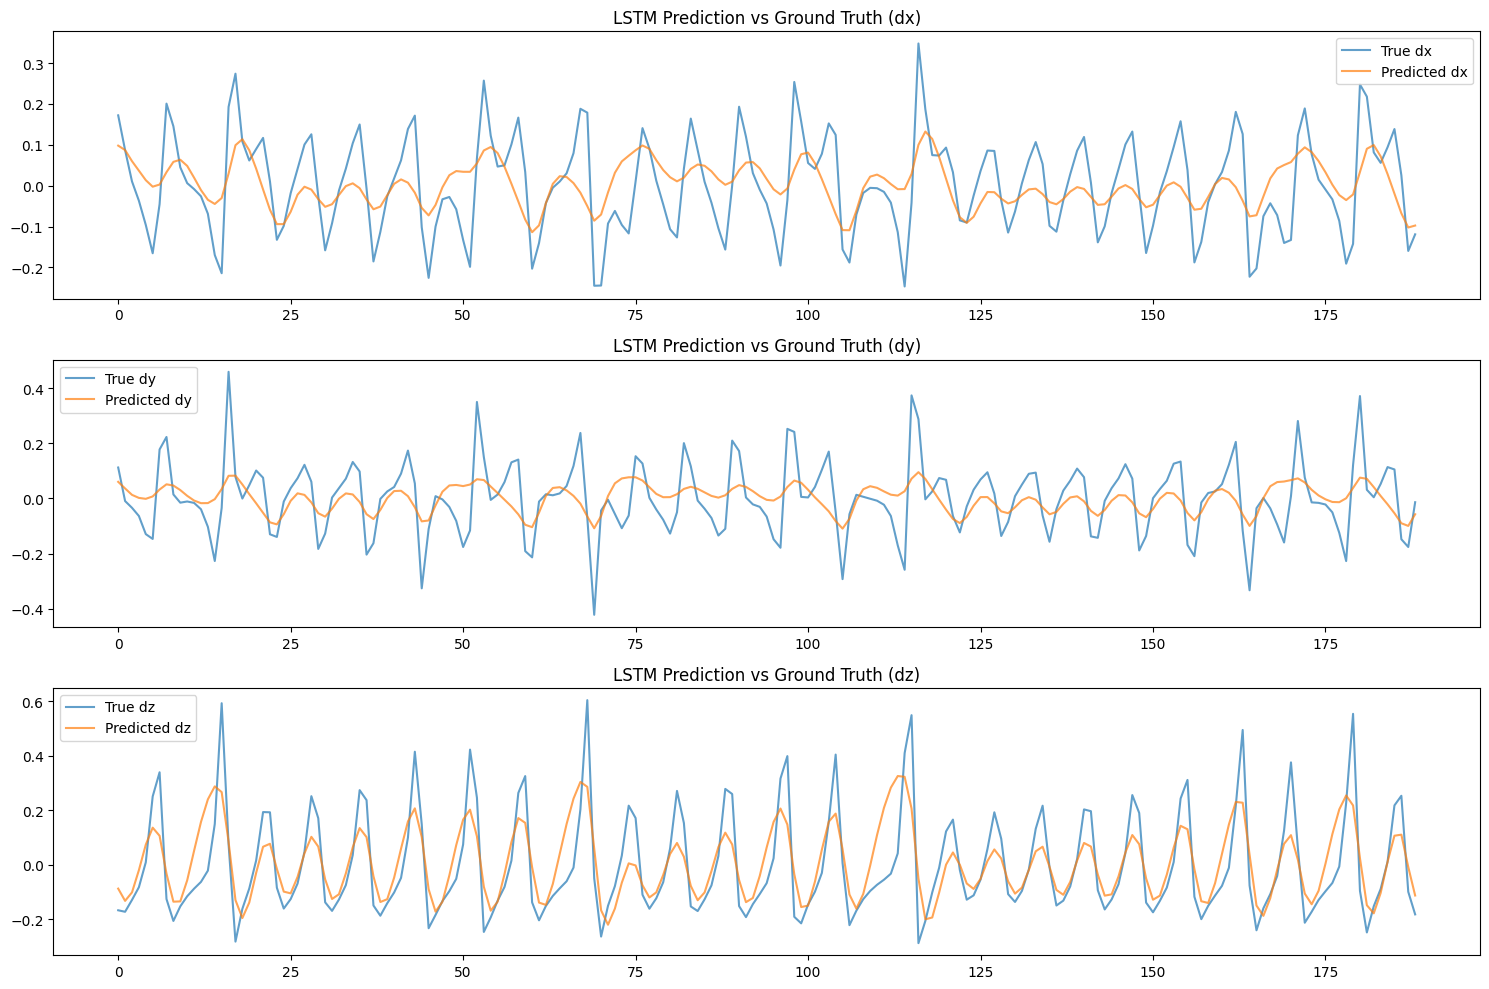

✅ Finished 'run_non_adaptive' in 17.88 seconds.



In [21]:
run_non_adaptive()

We have played with dt in the cell of data gen to check non adaptive for small time step and big one, and if you wanna try it, just go and change dt too so that you end up getting the same results in the pdf, we used 0.1 and 0.02 for our tests.